In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import diffusion_gosai_update
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
import dataloader_gosai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import oracle
from scipy.stats import pearsonr
import torch
from tqdm import tqdm
import diffusion_gosai_cfg
from utils import set_seed
set_seed(0, use_cuda=True)
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

=> Seed of the run set to 0


In [ ]:
base_path = '/data/scratch/wangchy/seqft/'

In [3]:
# our model
CKPT_PATH = os.path.join(base_path, 'mdlm/reward_bp_results_final/finetuned.ckpt')
NUM_SAMPLE_BATCHES = 10
NUM_SAMPLES_PER_BATCH = 64

In [4]:
# reinitialize Hydra
GlobalHydra.instance().clear()

# Initialize Hydra and compose the configuration|
initialize(config_path="configs_gosai", job_name="load_model")
cfg = compose(config_name="config_gosai.yaml")
cfg.eval.checkpoint_path = CKPT_PATH

/tmp/ipykernel_1938153/1132405131.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs_gosai", job_name="load_model")


In [5]:
model = diffusion_gosai_update.Diffusion(cfg, eval=False).cuda()
model.load_state_dict(torch.load(cfg.eval.checkpoint_path))
model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [6]:
old_path = os.path.join(base_path, 'mdlm/outputs_gosai/pretrained.ckpt')
old_model = diffusion_gosai_update.Diffusion.load_from_checkpoint(old_path, config=cfg)
old_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [7]:
zero_alpha_path = os.path.join(base_path, 'mdlm/reward_bp_results_final/zero_alpha.ckpt')
zero_alpha_model = diffusion_gosai_update.Diffusion(cfg).cuda()
zero_alpha_model.load_state_dict(torch.load(zero_alpha_path))
zero_alpha_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [8]:
cfg_cfg = compose(config_name="config_gosai.yaml")
cfg_cfg.model.cls_free_guidance=True
cfg_cfg.model.cls_free_weight=10
cfg_cfg.model.cls_free_prob=0.1
cfg_path = os.path.join(base_path, 'mdlm/outputs_gosai/cfg.ckpt')
cfg_cfg.eval.checkpoint_path = cfg_path
cfg_model = diffusion_gosai_cfg.Diffusion(cfg_cfg, eval=False).cuda()
cfg_model.load_state_dict(torch.load(cfg_cfg.eval.checkpoint_path)['state_dict'])
cfg_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

### Sample from the generative model

In [9]:
all_detoeknized_samples = []
all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples.extend(detokenized_samples)
all_raw_samples = torch.concat(all_raw_samples)
model_logl = old_model.get_likelihood(all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]


In [10]:
reward_model_bs = oracle.get_gosai_oracle(mode='train')
reward_model_bs.eval()

wandb: Currently logged in as: wangchy18 (chenyuwang). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [11]:
tds_all_detoeknized_samples = []
tds_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_TDS(reward_model=reward_model_bs, alpha=0.5, guidance_scale=1000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    tds_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    tds_all_detoeknized_samples.extend(detokenized_samples)
tds_all_raw_samples = torch.concat(tds_all_raw_samples)
tds_model_logl = old_model.get_likelihood(tds_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.22s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:13<00:00, 31.34s/it]

In [12]:
cg_all_detoeknized_samples = []
cg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_CG(reward_model=reward_model_bs, guidance_scale=300000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    cg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cg_all_detoeknized_samples.extend(detokenized_samples)
cg_all_raw_samples = torch.concat(cg_all_raw_samples)
cg_model_logl = old_model.get_likelihood(cg_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.89s/it]


In [13]:
old_all_detoeknized_samples = []
old_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    old_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    old_all_detoeknized_samples.extend(detokenized_samples)
old_all_raw_samples = torch.concat(old_all_raw_samples)
old_model_logl = old_model.get_likelihood(old_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]

In [14]:
smc_all_detoeknized_samples = []
smc_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_SMC(reward_model=reward_model_bs, alpha=0.5, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    smc_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    smc_all_detoeknized_samples.extend(detokenized_samples)
smc_all_raw_samples = torch.concat(smc_all_raw_samples)
smc_model_logl = old_model.get_likelihood(smc_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.04s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.88s/it]

In [15]:
zero_alpha_all_detoeknized_samples = []
zero_alpha_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = zero_alpha_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    zero_alpha_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    zero_alpha_all_detoeknized_samples.extend(detokenized_samples)
zero_alpha_all_raw_samples = torch.concat(zero_alpha_all_raw_samples)
zero_alpha_model_logl = old_model.get_likelihood(zero_alpha_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.84s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]

In [16]:
cfg_all_detoeknized_samples = []
cfg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = cfg_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH, w=10)
    cfg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cfg_all_detoeknized_samples.extend(detokenized_samples)
cfg_all_raw_samples = torch.concat(cfg_all_raw_samples)
cfg_model_logl = old_model.get_likelihood(cfg_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.86s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]

In [17]:
compare = np.concatenate((old_model_logl.detach().cpu().numpy(), 
                          zero_alpha_model_logl.detach().cpu().numpy(),
                          model_logl.detach().cpu().numpy(),
                          cfg_model_logl.detach().cpu().numpy(),
                          cg_model_logl.detach().cpu().numpy(),
                          smc_model_logl.detach().cpu().numpy(),
                          tds_model_logl.detach().cpu().numpy(),
                         ), axis= 0)

In [18]:
np.median(compare.reshape(-1, 640), axis=-1)

array([-262.33215, -281.08643, -264.49316, -264.62387, -265.87946,
       -258.89484, -258.88095], dtype=float32)

In [19]:
highexp_kmers_99, n_highexp_kmers_99, highexp_kmers_999, n_highexp_kmers_999, highexp_set_sp_clss_999, highexp_preds_999, highexp_seqs_999 = oracle.cal_highexp_kmers(return_clss=True)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9


### Pred-Activity based on Eval Oracle

In [20]:
# Calculate the predictions of the oracle model on the generated sequences
generated_preds = oracle.cal_gosai_pred_new(all_detoeknized_samples, mode='eval')
old_generated_preds = oracle.cal_gosai_pred_new(old_all_detoeknized_samples, mode='eval')
zero_alpha_preds = oracle.cal_gosai_pred_new(zero_alpha_all_detoeknized_samples, mode='eval')
cfg_preds = oracle.cal_gosai_pred_new(cfg_all_detoeknized_samples, mode='eval')
cg_preds = oracle.cal_gosai_pred_new(cg_all_detoeknized_samples, mode='eval')
smc_preds = oracle.cal_gosai_pred_new(smc_all_detoeknized_samples, mode='eval')
tds_preds = oracle.cal_gosai_pred_new(tds_all_detoeknized_samples, mode='eval')

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.0


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.0


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.9


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.0


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.0


In [21]:
compare = np.concatenate((old_generated_preds[:,0],
                            zero_alpha_preds[:,0],
                            generated_preds[:,0],
                            cfg_preds[:,0],
                            cg_preds[:,0],
                            smc_preds[:,0],
                            tds_preds[:,0]), axis= 0)

In [22]:
np.median(compare.reshape(-1, 640), axis=-1)

array([0.24600142, 6.433606  , 5.5604706 , 4.936166  , 3.3199525 ,
       4.721697  , 4.4666824 ], dtype=float32)

### ATAC-Acc

In [23]:
generated_preds_atac = oracle.cal_atac_pred_new(all_detoeknized_samples)
old_generated_preds_atac = oracle.cal_atac_pred_new(old_all_detoeknized_samples)
zero_alpha_preds_atac = oracle.cal_atac_pred_new(zero_alpha_all_detoeknized_samples)
cfg_preds_atac = oracle.cal_atac_pred_new(cfg_all_detoeknized_samples)
cg_preds_atac = oracle.cal_atac_pred_new(cg_all_detoeknized_samples)
smc_preds_atac = oracle.cal_atac_pred_new(smc_all_detoeknized_samples)
tds_preds_atac = oracle.cal_atac_pred_new(tds_all_detoeknized_samples)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.9


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.9


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.3


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.5


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.7


In [24]:
compare = np.concatenate((old_generated_preds_atac[:,1],
                            zero_alpha_preds_atac[:,1],
                            generated_preds_atac[:,1],
                            cfg_preds_atac[:,1],
                            cg_preds_atac[:,1],
                            smc_preds_atac[:,1],
                            tds_preds_atac[:,1]), axis= 0)

In [25]:
(old_generated_preds_atac[:,1]>0.5).sum()/640

0.0078125

In [26]:
(generated_preds_atac[:,1]>0.5).sum()/640

0.91875

In [27]:
(zero_alpha_preds_atac[:,1]>0.5).sum()/640

0.8125

In [28]:
(cfg_preds_atac[:,1]>0.5).sum()/640

0.9078125

In [29]:
(cg_preds_atac[:,1]>0.5).sum()/640

0.0

In [30]:
(smc_preds_atac[:,1]>0.5).sum()/640

0.415625

In [31]:
(tds_preds_atac[:,1]>0.5).sum()/640

0.528125

### 3-mer Pearson Correlation

In [32]:
def compare_kmer(kmer1, kmer2, n_sp1, n_sp2, title):
    kmer_set = set(kmer1.keys()) | set(kmer2.keys())
    counts = np.zeros((len(kmer_set), 2))
    for i, kmer in enumerate(kmer_set):
        if kmer in kmer1:
            counts[i][1] = kmer1[kmer] * n_sp2 / n_sp1
        if kmer in kmer2:
            counts[i][0] = kmer2[kmer]
            
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.scatter(counts[:, 0], counts[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("k-mer train top 0.1% count")
    ax.set_ylabel("k-mer generated count")
    ax.set_ylim((-5, np.max(counts) + 5))
    ax.set_xlim((-5, np.max(counts) + 5))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(0.5, 0.5, f"Pearson Corr: {pearsonr(counts[:, 0], counts[:, 1])[0]:.3f}")
    plt.show()

    print(pearsonr(counts[:, 0], counts[:, 1]))

In [33]:
generated_kmer = oracle.count_kmers(all_detoeknized_samples)
old_generated_kmer = oracle.count_kmers(old_all_detoeknized_samples)
zero_alpha_generated_kmer = oracle.count_kmers(zero_alpha_all_detoeknized_samples)
cfg_generated_kmer = oracle.count_kmers(cfg_all_detoeknized_samples)
cg_generated_kmer = oracle.count_kmers(cg_all_detoeknized_samples)
smc_generated_kmer = oracle.count_kmers(smc_all_detoeknized_samples)
tds_generated_kmer = oracle.count_kmers(tds_all_detoeknized_samples)

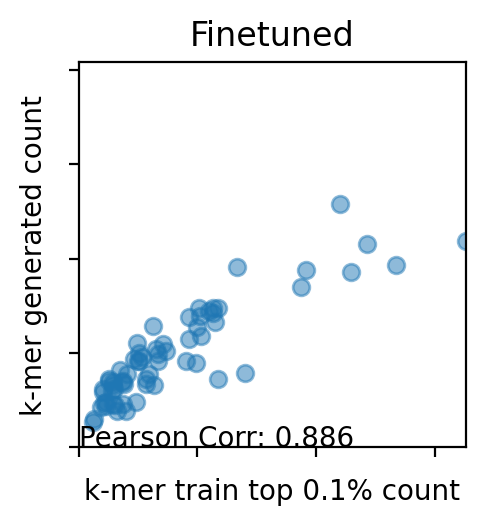

PearsonRResult(statistic=0.8860917532966844, pvalue=2.2404427604079654e-22)


In [34]:
compare_kmer(highexp_kmers_999, generated_kmer, n_highexp_kmers_999, len(all_detoeknized_samples), title=r"Finetuned")

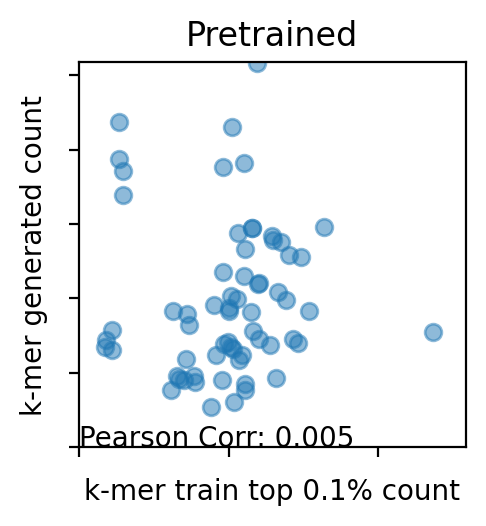

PearsonRResult(statistic=0.004746852254467887, pvalue=0.9703043620570406)


In [35]:
compare_kmer(highexp_kmers_999, old_generated_kmer, n_highexp_kmers_999, len(old_all_detoeknized_samples), title=r"Pretrained")

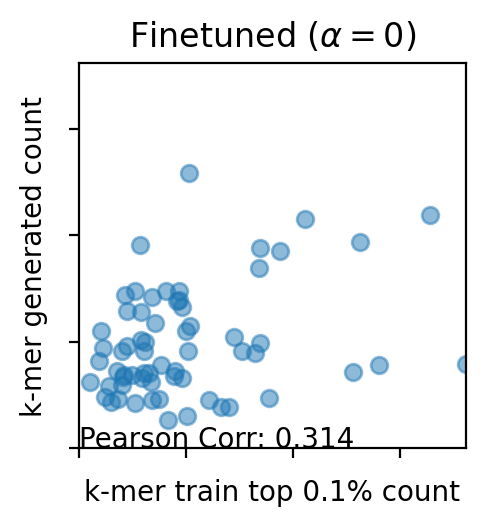

PearsonRResult(statistic=0.31374225684921553, pvalue=0.01158417101533566)


In [36]:
compare_kmer(highexp_kmers_999, zero_alpha_generated_kmer, n_highexp_kmers_999, len(zero_alpha_all_detoeknized_samples), 
             title=r"Finetuned ($\alpha=0$)")

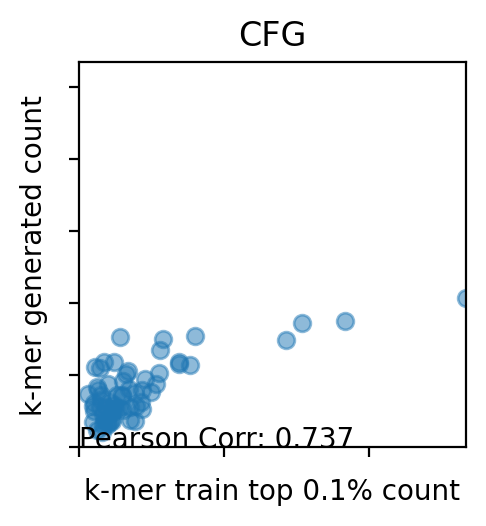

PearsonRResult(statistic=0.737124902150346, pvalue=3.783682253221068e-12)


In [37]:
compare_kmer(highexp_kmers_999, cfg_generated_kmer, n_highexp_kmers_999, len(cfg_all_detoeknized_samples), title=r"CFG")

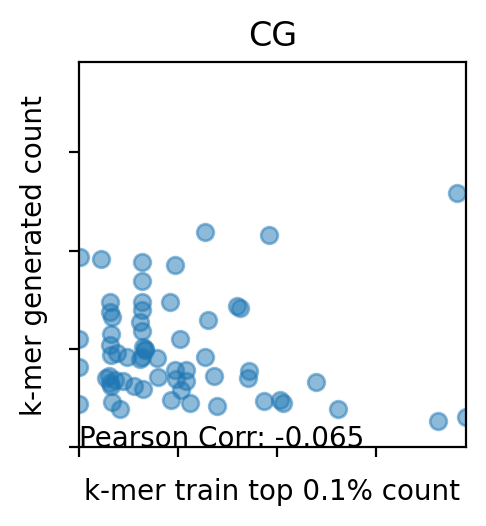

PearsonRResult(statistic=-0.06476854216098796, pvalue=0.6111234448123178)


In [38]:
compare_kmer(highexp_kmers_999, cg_generated_kmer, n_highexp_kmers_999, len(cg_all_detoeknized_samples), title=r"CG")

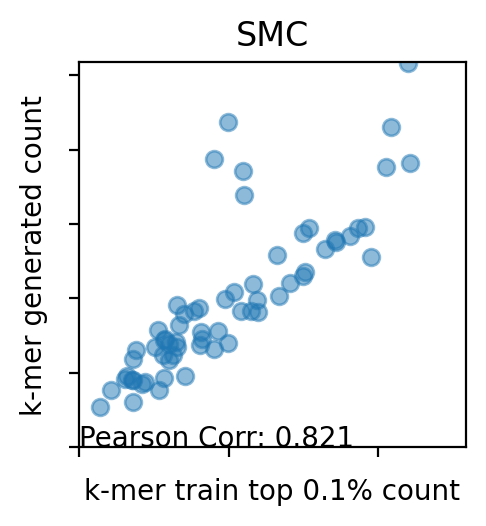

PearsonRResult(statistic=0.8207708018225125, pvalue=1.0235929170549717e-16)


In [39]:
compare_kmer(highexp_kmers_999, smc_generated_kmer, n_highexp_kmers_999, len(smc_all_detoeknized_samples), title=r"SMC")

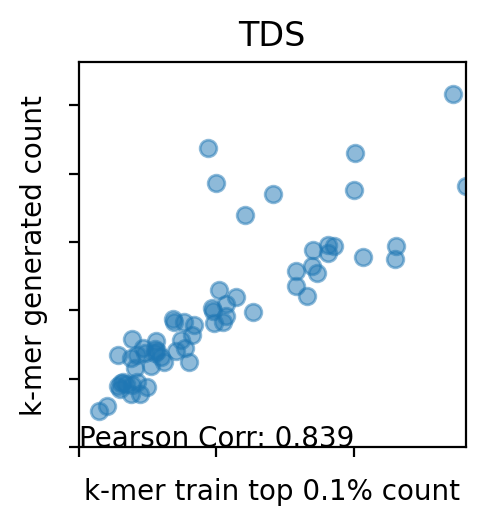

PearsonRResult(statistic=0.8386283242620288, pvalue=5.2428067579234504e-18)


In [40]:
compare_kmer(highexp_kmers_999, tds_generated_kmer, n_highexp_kmers_999, len(tds_all_detoeknized_samples), title=r"TDS")

### JASPER Motif Analysis

In [41]:
from grelu.interpret.motifs import scan_sequences

In [42]:
motif_count = scan_sequences(all_detoeknized_samples, 'jaspar')
motif_count_sum = motif_count['motif'].value_counts()
motif_count_old = scan_sequences(old_all_detoeknized_samples, 'jaspar')
motif_count_old_sum = motif_count_old['motif'].value_counts()
motif_count_zero_alpha = scan_sequences(zero_alpha_all_detoeknized_samples, 'jaspar')
motif_count_zero_alpha_sum = motif_count_zero_alpha['motif'].value_counts()
motif_count_cfg = scan_sequences(cfg_all_detoeknized_samples, 'jaspar')
motif_count_cfg_sum = motif_count_cfg['motif'].value_counts()
motif_count_cg = scan_sequences(cg_all_detoeknized_samples, 'jaspar')
motif_count_cg_sum = motif_count_cg['motif'].value_counts()
motif_count_smc = scan_sequences(smc_all_detoeknized_samples, 'jaspar')
motif_count_smc_sum = motif_count_smc['motif'].value_counts()
motif_count_tds = scan_sequences(tds_all_detoeknized_samples, 'jaspar')
motif_count_tds_sum = motif_count_tds['motif'].value_counts()
motif_count_top = scan_sequences(highexp_seqs_999, 'jaspar')
motif_count_top_sum = motif_count_top['motif'].value_counts()

Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.


In [43]:
motifs_summary = pd.concat([motif_count_top_sum, motif_count_sum, motif_count_old_sum, motif_count_zero_alpha_sum,
                            motif_count_cfg_sum, motif_count_cg_sum, motif_count_smc_sum, motif_count_tds_sum], axis=1)
motifs_summary.columns = ['top_data', 'finetuend', 'pretrained', 'zero alpha', 'CFG', 'CG', 'SMC', 'TDS']
motifs_summary.corr(method='spearman')

,top_data,finetuend,pretrained,zero alpha,CFG,CG,SMC,TDS
top_data,1.000000,0.910023,0.324606,0.535054,0.854970,0.176220,0.822897,0.874839
finetuend,0.910023,1.000000,0.120505,0.703689,0.897307,0.142525,0.751965,0.794379
pretrained,0.324606,0.120505,1.000000,-0.023900,0.096322,0.188730,0.443626,0.404180
zero alpha,0.535054,0.703689,-0.023900,1.000000,0.587259,0.222157,0.455822,0.386102
CFG,0.854970,0.897307,0.096322,0.587259,1.000000,0.111964,0.758670,0.795839
CG,0.176220,0.142525,0.188730,0.222157,0.111964,1.000000,0.222207,0.135639
SMC,0.822897,0.751965,0.443626,0.455822,0.758670,0.222207,1.000000,0.808855
TDS,0.874839,0.794379,0.404180,0.386102,0.795839,0.135639,0.808855,1.000000
